Using the other object as test set 🤪

In [10]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

objectwidth = 100
objectheight = 100
xspacing = 116
yspacing = 300
xstart = 293
ystart = 445
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 225

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])

objectinfo = pd.read_csv('Parameters2.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)

del coorddf
del objectCoordinates
del paths_sorted

objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)
objectinfo.reset_index(drop=True, inplace=True)

objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

for index, object in objectinfo.iterrows():
    objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
del integrals

aggregate = np.sum(objects, axis=(0))

emptyRatio = 30
limit = np.percentile(aggregate, emptyRatio)
testmask = aggregate >= limit

testobjects = objects
testobjectinfo = objectinfo
del objects
del objectinfo

In [14]:
# Read train data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187
separate_test = True
objectsplit = 1
upsamplingratio = 1
positive_multiplier = 1

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

layersPerObject = endlayer // objectsplit
testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
# testEnd = endlayer

objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)

zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
testzs = [objectinfo.copy().assign(zstart=testEnd, zend=endlayer)]
trainobjectinfo = pd.concat(zs, ignore_index=True)
# This line removes all the lines from the dataframe that aren't created because of the positive_multiplier
trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]
testobjectinfo = pd.concat(testzs, ignore_index=True)

trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

del zs
del coorddf
del objectCoordinates
del objectinfo

trainobjects = np.full((len(trainobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), endlayer-testEnd, objectheight, objectwidth), np.nan)

for index, object in trainobjectinfo.iterrows():
    trainobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]
for index, object in testobjectinfo.iterrows():
    testobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

aggregate = np.sum(trainobjects, axis=(0,1))

emptyRatio = 47
limit = np.percentile(aggregate, emptyRatio)
trainmask = aggregate >= limit
trainmask = np.repeat([trainmask], layersPerObject, 0)

testmask = trainmask

del aggregate
del limit
del integrals
del block
del paths

assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [19]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

def preprocess(objects, type, sharpening='none'):
    rtn = []
    # print(rtn.shape)
    for index, object in enumerate(objects):
        sharpened = object
        if(sharpening != 'none'):
            sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
            sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            rtn.append(xs)
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            avg = np.nanmean(xs)
            stddev = np.nanstd(xs)
            xs = (xs - avg) / avg
            rtn.append(xs)
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    # c, z, y, x = objects.shape

    outlierValues = []
    index = 0
    # return objects
    for object in objects:
        z, y, x = object.shape
        # Step 1: calculate neighbourhood
        neighbourkernel = np.ones((neighbourhoodSetting, neighbourhoodSetting))
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        ys = neighbourhoodValues[0:z-windowSize+1]
        xs = object[offset:z-endoffset]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues.append(outliers)
        else:
            with warnings.catch_warnings():
                line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                p = np.poly1d(line)
                outlierValues.append(p(xs) - ys)
            # plt.scatter(xs[filter].flatten(), ys[filter].flatten())
            # plt.axline((-0.1, p(-0.1)), (0, p(0)), linewidth=2, color='b')
            # plt.figure()
            assert(xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        index+=1
    # print("okidk ", np.average(np.isfinite(outlierValues)))
    # assert(np.average(np.isfinite(outlierValues)) > 0.4)
    return outlierValues

def encode(outlierobjects, type, buckets, histnormalise, minval=0, maxval=0, transformer=None):
    numberOfObjects = len(outlierobjects)
    X = np.full((numberOfObjects, buckets), np.nan)
    raw = np.concatenate([oo.flatten() for oo in outlierobjects])
    filter = np.isfinite(raw)
    minval = np.min(raw[filter]) if minval == 0 else minval
    maxval = np.max(raw[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    return X, minval, maxval, edges, transformer

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, histnormalise, edges):
    plt.hist(edges[0:-1], weights=Xtrain[2], bins=edges)
    plt.yscale('log')
    plt.figure()
    scaler = StandardScaler()
    Xtrain = scaler.fit_transform(Xtrain)
    plt.hist(edges[0:-1], weights=Xtrain[2], bins=edges)
    plt.yscale('log')
    plt.figure()

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform")    
    if (histnormalise == True):
        clf = Pipeline([('scaler', RobustScaler()), ('classifier', neighbors.KNeighborsClassifier(n_neighbors))])
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict(Xtest)
    graph = (clf['classifier'] if histnormalise == True else clf).kneighbors(Xtest, return_distance=False)
    # print(graph)
    # print(yfit)
    return cvs.mean(), metrics.roc_auc_score(Ytest, yfit), metrics.precision_score(Ytest, yfit, zero_division=0), metrics.recall_score(Ytest, yfit, zero_division=0)

In [16]:
# parameter settings
types = ['scatter', 'spatstat', 'moran', ]
sharpening = ['none', 'direct', 'diagonal']
windowsizes = [1, 3, 5, 7]
neighbourhoodSetting = ['grid', 'euclidean']
bins = [30, 60, 90, 120, 150]
histnormalise = [True, False]
k = [3,4,5,10,15,20]

In [17]:
# Narrow settings for iterating
types = ['moran', 'spatstat', 'moran', ]
windowsizes = [1, 3, 5]
neighbourhoodsize = [3, 5, 7]
bins = [30]
histnormalise = [True]
k = [5,10,15]

09:39:58 Processing type:  moran


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_38641/3201722458.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(sharpening != 'none'):
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_38641/3201722458.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],


09:39:58 Processing windowSize:  1  neighbourhood:  3


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_38641/3201722458.py:27: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(xs)
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


AssertionError: Expected filter to have two values, got: 1

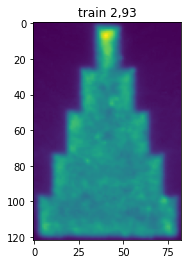

<Figure size 432x288 with 0 Axes>

In [20]:
# Now to tie it all together...
def doStuff ():
    columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'cv-auc', 'test-auc', 'test-precision', 'test-recall']
    results = pd.DataFrame(columns=columns)
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    for type in types:
        print(datetime.now().strftime("%H:%M:%S"), "Processing type: ", type)
        # trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
        trainpreprocessed =preprocess(trainobjects, type, trainmask)
        testpreprocessed =preprocess(testobjects, type, testmask)
        plt.imshow(trainobjects[2][93])
        plt.title("train 2,93")
        plt.figure()
        # plt.imshow(testobjects[0][0])
        # plt.title("test 0,0")
        # plt.figure()
        # plt.imshow(trainpreprocessed[0][0])
        # plt.title("trainpreprocessed 0,0")
        # plt.figure()
        # plt.imshow(testpreprocessed[0][0])
        # plt.title("testpreprocessed 0,0")
        # plt.figure()
        for windowsize in windowsizes:
            for nSetting in neighbourhoodsize:
                print(datetime.now().strftime("%H:%M:%S"), "Processing windowSize: ", windowsize, " neighbourhood: ", nSetting)
                # trainoutliers = np.apply_along_axis(calculateoutliers, 1, trainpreprocessed, type, nSetting, windowsize)
                trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
                testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)

                plt.imshow(trainoutliers[2][93])
                plt.title("trainoutliers 2,93, porosity " + str(trainobjectinfo.loc[2,"Porosity"]))
                plt.figure()
                # plt.imshow(testoutliers[0][0])
                # plt.title("testoutliers 0,0")
                # plt.figure()
                for histnorm in histnormalise:
                    for bincount in bins:
                        print(datetime.now().strftime("%H:%M:%S"), "Processing histnorm: ", histnorm, " bins: ", bincount)
                        Xtrain, minval, maxval, edges, transformer = encode(trainoutliers, type, bincount, histnorm)
                        Xtest, _, _, _, _ = encode(testoutliers, type, bincount, histnorm, minval=minval, maxval=maxval, transformer=transformer)
                        # Add encode for test as well
                        for n_neighbors in k:
                            cvscore, score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, histnorm, edges)
                            nextRow =  pd.DataFrame([[type, 'none', windowsize, nSetting, bincount, histnorm, n_neighbors, cvscore, score, precision, recall]], columns=columns)
                            results = pd.concat([results, nextRow])
                        return
        return
doStuff()

In [21]:
print("trainobjects (numpy): " + str(hash(np.array2string(trainobjects))))
print("traininfo: " + str(hash(trainobjectinfo.to_string())))
print("testobjects (numpy): " + str(hash(np.array2string(testobjects))))
print("testinfo: " + str(hash(testobjectinfo.to_string())))

trainobjects (numpy): -2166023118416099643
traininfo: 412508232648793926
testobjects (numpy): 4546364536014759216
testinfo: -8326825392638724975


In [24]:
trainobjectinfo.to_csv("v3train.csv", index=False, header=True)
testobjectinfo.to_csv("v3test.csv", index=False, header=True)

In [6]:
np.savetxt("v3train.csv", trainobjects.flatten(), delimiter=",", fmt='%1.3e')
np.savetxt("v3test.csv", testobjects.flatten(), delimiter=",", fmt='%1.3e')

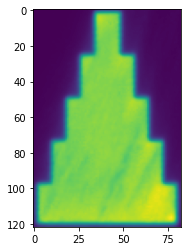

In [7]:
plt.imshow(trainobjects[0][0])